In [1]:
import numpy as np 
import pandas as pd 
import os
from PIL import Image
import cv2
import torch
from torchvision import transforms
from matplotlib import pyplot as plt
from tqdm import tqdm
from pytorch_msssim import ms_ssim

In [2]:
data_dir = '/gpfs01/berens/data/data/eyepacs/data_processed/images/'
csv_file = '/gpfs01/berens/data/data/eyepacs/data_processed_clahe_resized/metadata/splits_longitudinal_test/qual_eval_train.csv'
gen_dir = '/gpfs01/berens/user/iilanchezian/Projects/guided-diffusion/' \
          'no_rotate_4_class_balancing_trainv2/'

In [3]:
df = pd.read_csv(csv_file, low_memory=False)
print(f'Initial shape: {df.shape}')
good_qual_desc = ['Good', 'Excellent']
df = df[df['session_image_quality'].isin(good_qual_desc)]
df =df[~df['diagnosis_image_dr_level'].isna()]
print(f'Shape after filtering: {df.shape}')

Initial shape: (46921, 55)
Shape after filtering: (46921, 55)


In [4]:
all_files = df['image_path']
all_files = all_files.apply(lambda x: data_dir + x)
all_files = all_files.tolist()

In [20]:
# gen_img_file = '/gpfs01/berens/user/iilanchezian/Projects/guided-diffusion/' \
#                'diffusion_model_samples_no_rotate_5_class_balancing_only_train/' \
#                '103.png'

In [5]:
class eyepacsDataset(torch.utils.data.Dataset):
    def __init__(self, csv, img_dir, transform=None):
        self.img_dir = img_dir
        
        self.df = pd.read_csv(csv, low_memory=False)
        print(f'Initial shape: {self.df.shape}')
        good_qual_desc = ['Good', 'Excellent']
        self.df = self.df[self.df['session_image_quality'].isin(good_qual_desc)]
        self.df =self.df[~self.df['diagnosis_image_dr_level'].isna()]
        print(f'Shape after filtering: {self.df.shape}')
        
        self.img_files = self.df['image_path']
        self.img_files = self.img_files.apply(lambda x: img_dir + x)
        self.img_files = self.img_files.tolist()

        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        with Image.open(img_path) as image:
            image = np.asarray(image).astype(np.float64)
            image = cv2.resize(image, (256,256))
#             image = image.flatten()
#             image_tensor = torch.tensor(image)
        if self.transform:
            image = self.transform(image)
        return image

In [6]:
def get_eyepacs(csv, img_dir, batch_size=1000):
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = eyepacsDataset(csv, img_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return dataloader, len(dataset)

In [7]:
batch_size=200
device = "cuda:0"
eyepacs_dl, num_images = get_eyepacs(csv_file, data_dir, batch_size=batch_size)

Initial shape: (46921, 55)
Shape after filtering: (46921, 55)


In [9]:
with Image.open(gen_img_file) as sample_img:
    sample_img = np.asarray(sample_img).astype(np.float64)
#     sample_img_vec = sample_img.flatten()
#     sample_img_vec = np.tile(sample_img_vec, (batch_size,1))
#     sample_repeated = torch.tensor(sample_img_vec)
    sample_img_tensor = torch.tensor(sample_img)
    print(sample_img_tensor.shape)
    sample_img_tensor = sample_img_tensor.permute(2, 0, 1)
    print(sample_img_tensor.shape)
    sample_img_tensor = sample_img_tensor.unsqueeze(0)
# sample_repeated.to(device)

NameError: name 'gen_img_file' is not defined

In [10]:
dists = [] 
# pdist = torch.nn.PairwiseDistance(p=2)
# pdist.to(device)
lst = np.arange(int(num_images/batch_size)+1)
loader_iterator = iter(eyepacs_dl)
for i in tqdm(lst):
    batch = next(loader_iterator)
#     print(f'Batch shape: {batch.shape}, Sample shape: {sample_img_tensor.shape}')
#     dists_batch = pdist(sample_repeated, batch)
#     diff = batch - sample_img_tensor
#     diff = torch.square(diff)
#     dists_batch = torch.sum(diff, axis=1)
    diff = batch - sample_img_tensor
    dists_batch = torch.norm(diff, dim=(1,2,3), p=2.0)
#     dists_batch = torch.dist(batch, sample_img_tensor, p=2)
#     print(dists_batch.shape)
    dists_np = dists_batch.cpu().numpy().tolist()
    dists.extend(dists_np)

100%|██████████| 556/556 [1:20:03<00:00,  8.64s/it]


In [44]:
dists_2 = []
with Image.open(gen_img_file) as sample_img:
    sample_img = np.asarray(sample_img).astype(np.float64)
    sample_img_tensor = torch.tensor(sample_img)
    iter_range = np.arange(len(all_files))
    for i in tqdm(iter_range):
#         if i%500 == 0:
#             print(f'{i} done')
        file = all_files[i]
        with Image.open(file) as img:
            img = np.asarray(img).astype(np.float64)
            img = cv2.resize(img, (256,256))
            img_tensor = torch.tensor(img)
            dist = torch.dist(sample_img_tensor, img_tensor, p=2)
            dists_2.append(dist.numpy())
print(dists_2)

100%|██████████| 55503/55503 [1:19:29<00:00, 11.64it/s]


[array(30115.87130671), array(30687.23557931), array(30285.43571071), array(27252.92131589), array(21700.61928264), array(18317.06289399), array(28402.13934394), array(24233.03127706), array(25127.15926045), array(19961.24455821), array(24967.27948861), array(22315.62483721), array(24914.36638643), array(29000.29939932), array(33382.45492677), array(26157.69662786), array(25837.17877764), array(22991.82626228), array(20828.4914045), array(26908.12729688), array(24189.1812271), array(28525.12218313), array(33356.46441378), array(29213.28327576), array(22303.63307709), array(21684.71132647), array(22145.48771477), array(25657.07504885), array(24331.14726539), array(19947.71229364), array(19120.34603832), array(21132.13023011), array(19793.22341106), array(23712.92478665), array(26748.99068657), array(17776.39037108), array(20901.9565382), array(26700.91626822), array(25568.17831554), array(31804.30597714), array(28942.1220218), array(28519.21679543), array(25772.68919443), array(20025.49

In [13]:
print(len(dists))

55503


In [14]:
sorted_index = np.argsort(dists)

In [46]:
sorted_index_2 = np.argsort(dists_2)

In [15]:
k = 5
neighbors = [] 
for j in sorted_index[:k]:
    print(j)
    print(dists[j])
    neighbors.append(all_files[j])

39108
8613.709200309702
5153
9571.644914799128
19628
9642.967233300133
45150
9657.475300900334
20882
10068.065917170983


In [50]:
k = 5
neighbors_2 = [] 
for j in sorted_index_2[:k]:
    print(j)
    print(dists_2[j])
    neighbors_2.append(all_files[j])

39108
8613.709200309702
5153
9571.644914799128
19628
9642.967233300133
45150
9657.475300900334
20882
10068.065917170983


In [14]:
print(neighbors)

['/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-3_balance/1075746_11621700_Right Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-4/977816_10829337_Left Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-5/906978_10263744_Right Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-3_balance/1044308_11367196_Right Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-5/686488_8531619_Right Field 1.png']


In [52]:
print(neighbors_2)

['/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-5/865327_9937218_Left Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-3/1092844_11756737_Left Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-2_balance/1151669_12222670_Left Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-4/1038685_11321585_Left Field 1.png', '/gpfs01/berens/data/data/eyepacs/data_processed/images/images-set-2_balance/1140879_12137895_Left Field 1.png']


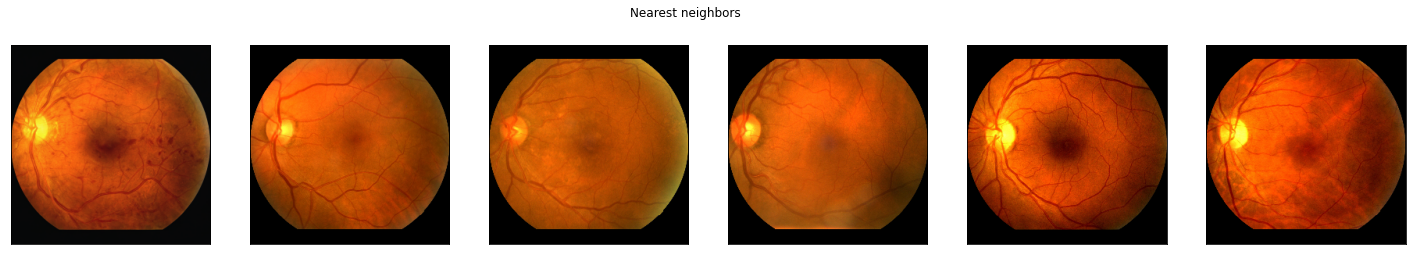

In [18]:
fig, axes = plt.subplots(1, 6, figsize=(25,4))
fig.suptitle('Nearest neighbors')

with Image.open(gen_img_file) as sample_img:
    sample_img = np.asarray(sample_img)
    axes[0].imshow(sample_img)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
for i,ax in enumerate(axes[1:]):
    with Image.open(neighbors[i]) as img:
        img = np.asarray(img)
        img = cv2.resize(img, (256,256))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('nearest_neighbors1.png', dpi=300)

In [22]:
def get_sample_image(gen_img_file):
    with Image.open(gen_img_file) as sample_img:
        sample_img = np.asarray(sample_img).astype(np.float64)
    #     sample_img_vec = sample_img.flatten()
    #     sample_img_vec = np.tile(sample_img_vec, (batch_size,1))
    #     sample_repeated = torch.tensor(sample_img_vec)
        sample_img_tensor = torch.tensor(sample_img)
#         print(sample_img_tensor.shape)
        sample_img_tensor = sample_img_tensor.permute(2, 0, 1)
#         print(sample_img_tensor.shape)
        sample_img_tensor = sample_img_tensor.unsqueeze(0)
    sample_img_tensor = sample_img_tensor.to(device)
    return sample_img_tensor

In [23]:
def get_dists(sample_img_tensor, dist_type='l2'):
    dists = [] 
    flipped_sample_img_tensor = transforms.functional.hflip(sample_img_tensor)
    # pdist = torch.nn.PairwiseDistance(p=2)
    # pdist.to(device)
    lst = np.arange(int(num_images/batch_size)+1)
#     loader_iterator = iter(eyepacs_dl)
    for batch in tqdm(eyepacs_dl):
#         batch = next(loader_iterator)
        batch = batch.to(device)
    #     print(f'Batch shape: {batch.shape}, Sample shape: {sample_img_tensor.shape}')
    #     dists_batch = pdist(sample_repeated, batch)
    #     diff = batch - sample_img_tensor
    #     diff = torch.square(diff)
    #     dists_batch = torch.sum(diff, axis=1)
        if dist_type == 'l2':
            diff = batch - sample_img_tensor
            dists_batch = torch.norm(diff, dim=(1,2,3), p=2.0)
            
            diff_flipped = batch - flipped_sample_img_tensor
            dists_batch_flipped = torch.norm(diff_flipped, dim=(1,2,3), p=2.0)
            
            dists_batch_final = torch.minimum(dists_batch, dists_batch_flipped)
        elif dist_type == 'mssim':
            sample_image_tensor = sample_img_tensor.repeat(batch.shape[0],1,1,1)
            dists_batch_final = ms_ssim(batch, sample_image_tensor, data_range=1, size_average=False )
            
        else:
            raise NotImplementedError
    #     dists_batch = torch.dist(batch, sample_img_tensor, p=2)
    #     print(dists_batch.shape)
        dists_np = dists_batch_final.cpu().numpy().tolist()
        dists.extend(dists_np)
    return dists

In [24]:
def get_neighbors(dists):
    sorted_index = np.argsort(dists)
#     sorted_index = sorted_index[::-1]
    k = 5
    neighbors = [] 
    for j in sorted_index[:k]:
#         print(j)
#         print(dists[j])
        neighbors.append(all_files[j])
    return neighbors 

In [25]:
def plot_neighbors(gen_img_file, save_filename):
    fig, axes = plt.subplots(1, 6, figsize=(25,4))
    fig.suptitle('Nearest neighbors')

    with Image.open(gen_img_file) as sample_img:
        sample_img = np.asarray(sample_img)
        axes[0].imshow(sample_img)
        axes[0].set_xticks([])
        axes[0].set_yticks([])
    for i,ax in enumerate(axes[1:]):
        with Image.open(neighbors[i]) as img:
            img = np.asarray(img)
            img = cv2.resize(img, (256,256))
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.savefig(save_filename, dpi=300)

In [26]:
# sample_files_DR = ['4.png', '14.png', '23.png', '29.png', '34.png', '37.png','48.png', '49.png',
#                    '53.png', '60.png', '64.png', '68.png', '70.png', '71.png', '96.png', '97.png',
#                    '100.png', '151.png', '196.png', '238.png', '240.png', '259.png', '315.png', '324.png', 
#                    '346.png', '348.png', '362.png', '422.png', '493.png', '534.png', '578.png', '702.png',
#                    '731.png', '752.png', '775.png', '874.png', '934.png', '961.png', ]
# sample_files_DR = ['568.png']
sample_files_DR = ['8.png', '16.png', '20.png', '227.png', '326.png', '624.png', '741.png']

100% 235/235 [1:23:02<00:00, 21.20s/it]
100% 235/235 [1:22:41<00:00, 21.11s/it]
100% 235/235 [1:20:29<00:00, 20.55s/it]
100% 235/235 [1:17:40<00:00, 19.83s/it]
100% 235/235 [1:16:19<00:00, 19.49s/it]
100% 235/235 [1:15:01<00:00, 19.15s/it]
100% 235/235 [1:15:54<00:00, 19.38s/it]


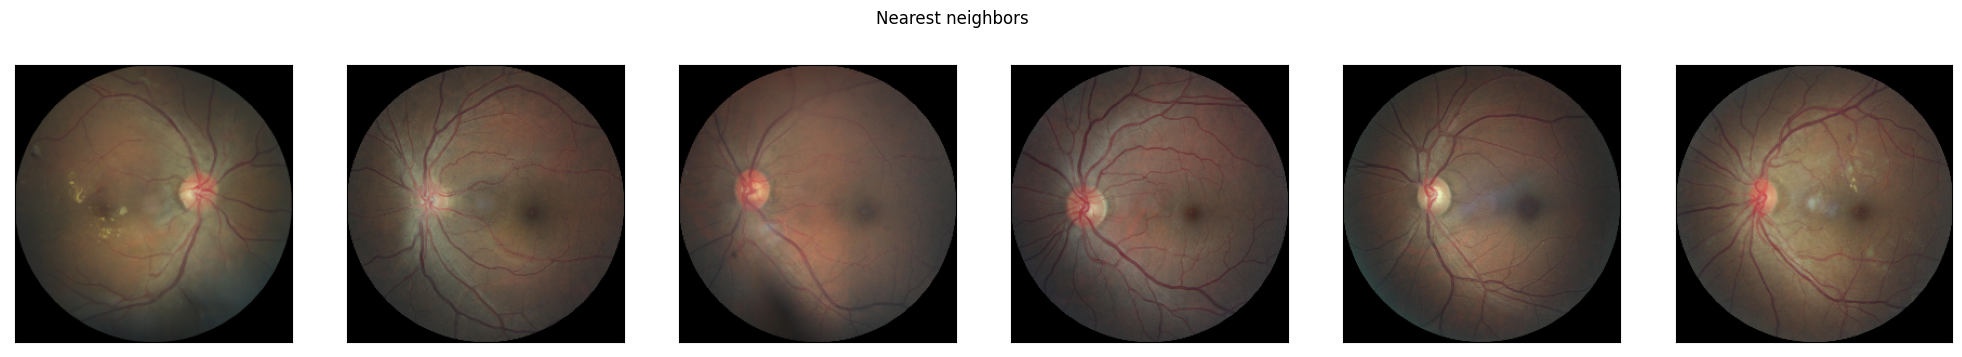

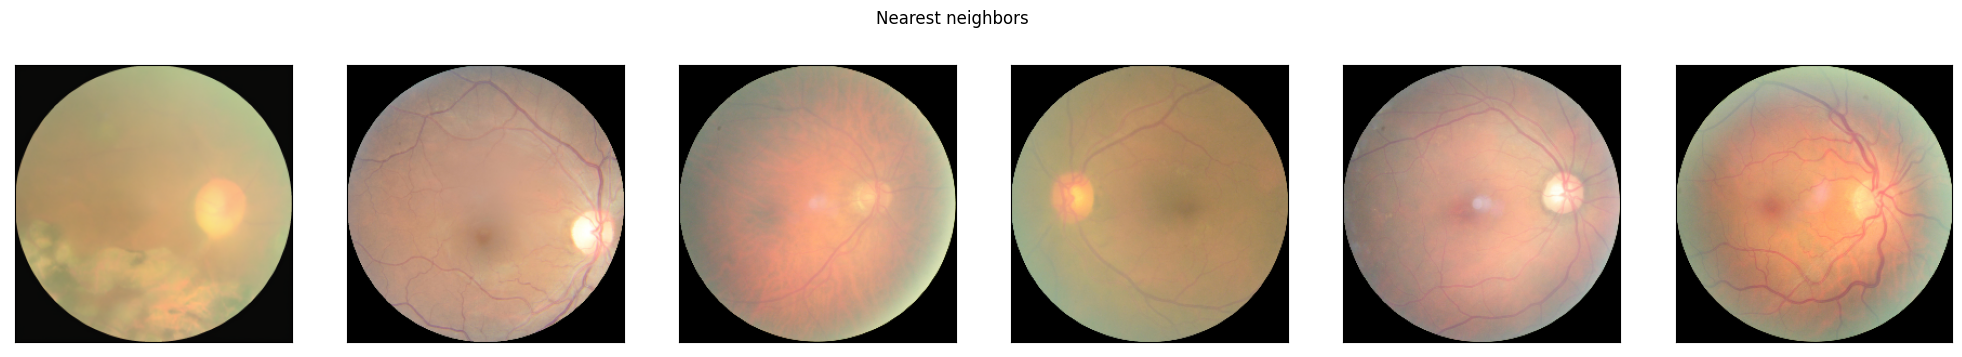

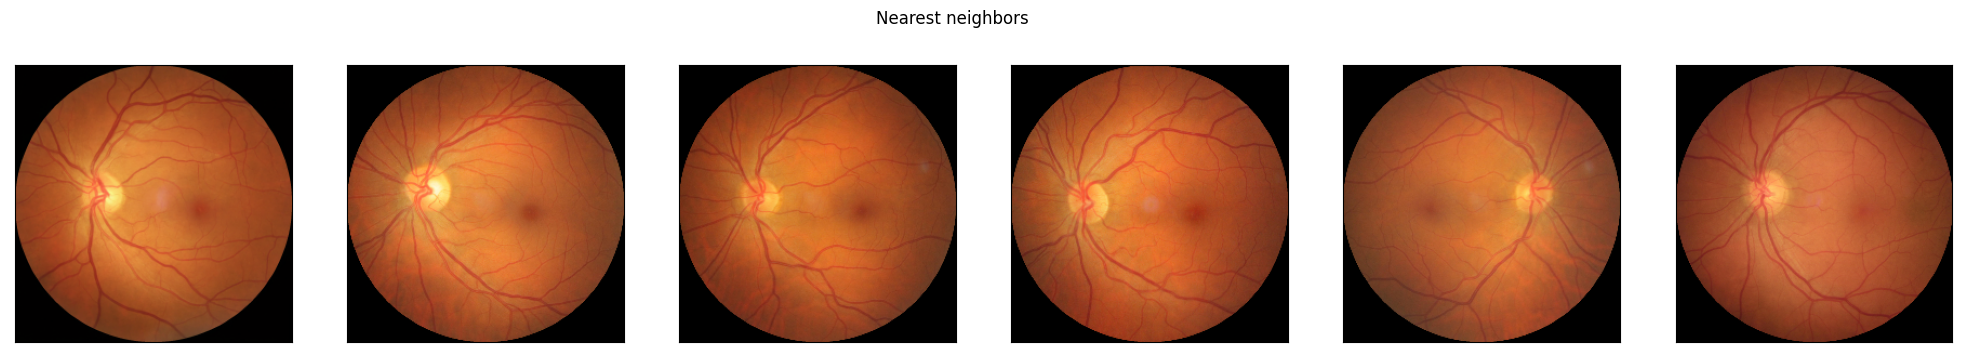

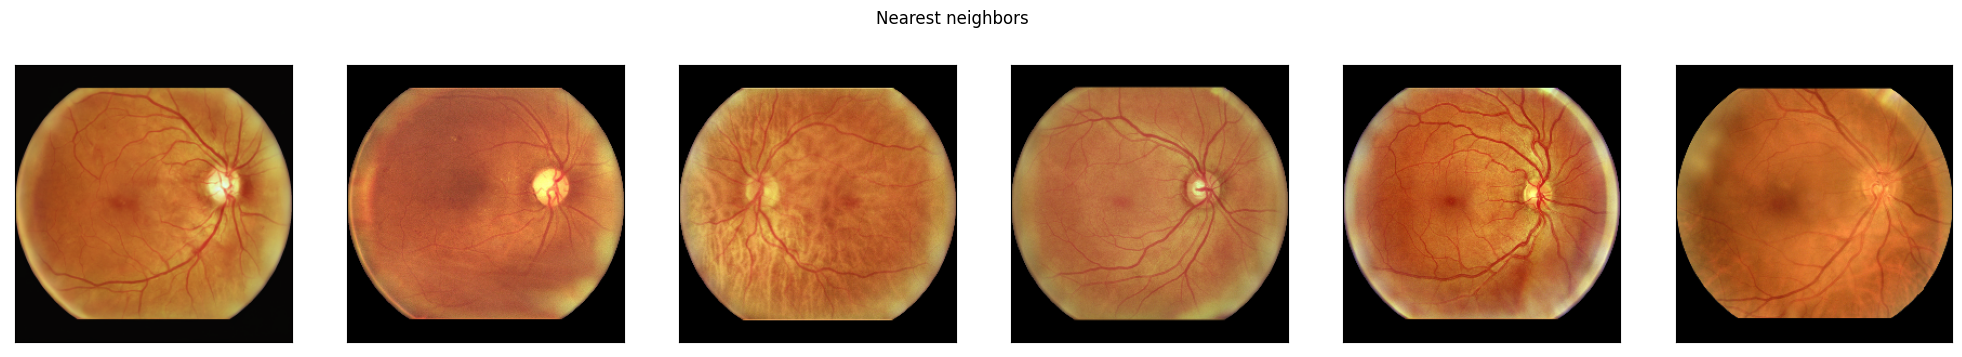

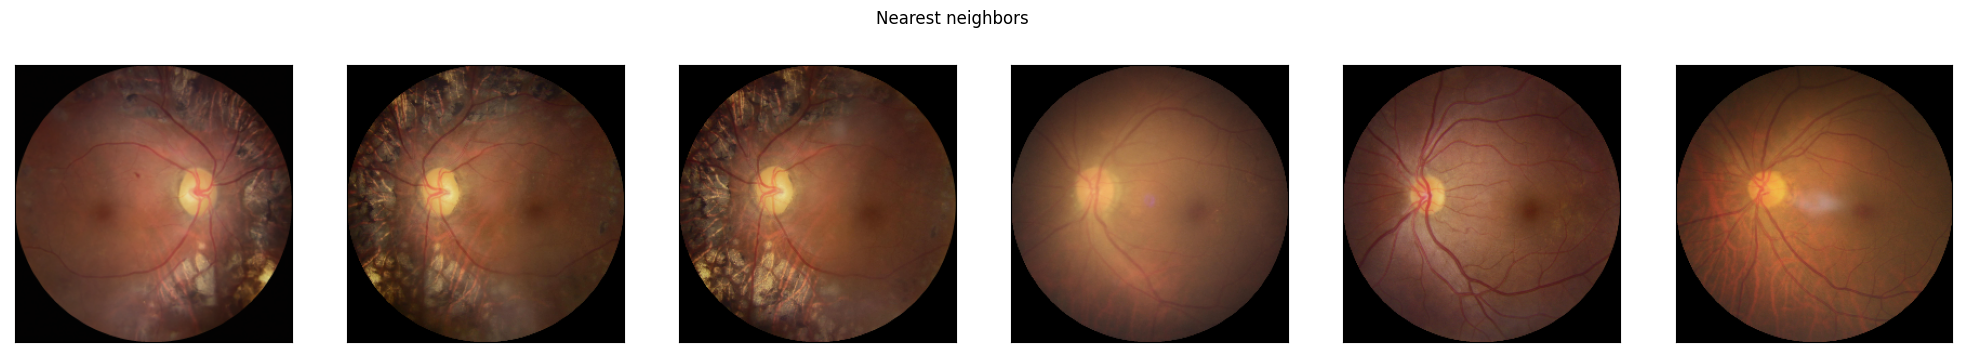

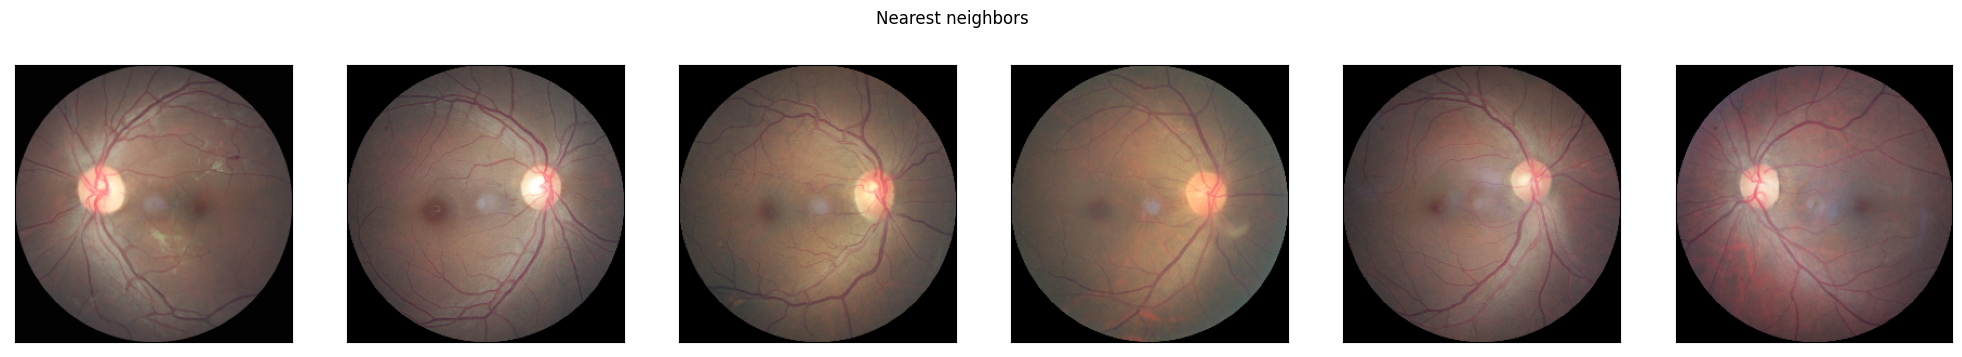

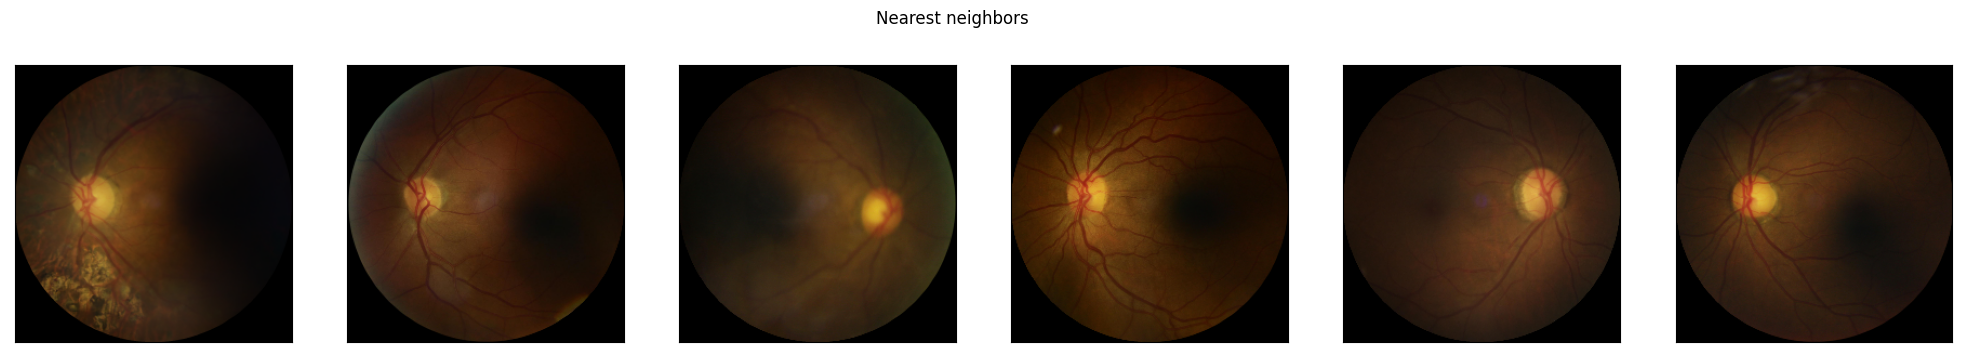

In [27]:
# sample_files = os.listdir(gen_dir)
np.random.seed(1636)
# img_files = np.random.choice(sample_files_DR, 100)
for t, sample_file in enumerate(sample_files_DR):
    sample_path = os.path.join(gen_dir, sample_file)
    sample_image_tensor = get_sample_image(sample_path)
    dists = get_dists(sample_image_tensor, dist_type='l2')
    neighbors = get_neighbors(dists)
    file_num = sample_file.split('.')[0]
    save_path = os.path.join('/gpfs01/berens/user/iilanchezian/Projects/guided-diffusion/Nearest neighbors/',
                             f'l2_pixel_space_NNs_{file_num}.png')
    plot_neighbors(sample_path, save_path)

In [16]:
torch.cuda.is_available()

True

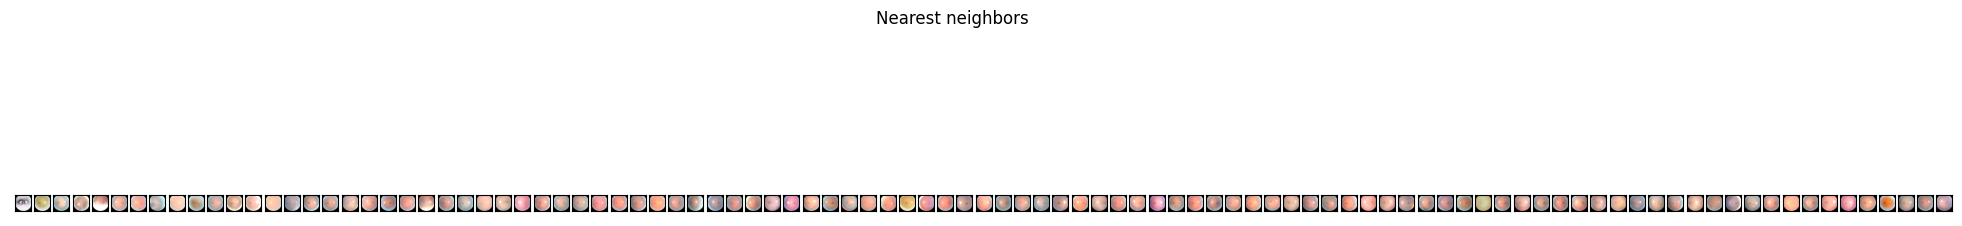

In [37]:
neighbors = get_neighbors(dists)
file_num = sample_file.split('.')[0]
save_path = os.path.join('/gpfs01/berens/user/iilanchezian/Projects/guided-diffusion/Nearest neighbors/',
                         f'mssim_pixel_space_NNs_535.png')
plot_neighbors(sample_path, save_path)